# The k-Armed Bandit Problem

In [ ]:
__author__ = "Adrian Sarno"

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Problem definition
Givent a slot machine with k arms (a.k.a. k-armed bandit), we want to estimate a function Q that to estimate the expected pay-off of each arm.

More formally:

                    r = Q[a]
where:
- Q: value function
* a: action (arm pulled)
* r: value of the reward (actually, this is the mean value or expectation, since the reward is a random variable)



### Test Models Matrix

Test Models is a matrix of 2000 rows and 10 columns. This matrix contains the expected values that we need to approximate. 

Each row stores the model parameters of one k-armed bandit (a slot machine with k arms). Each cell in the row stores the True Expected Value of the reward given by each of the k possible actions that the agent can do on the bandit (equivalent to a player pulling one of the k levers). 

The test models matrix will serve two purposes, one is as generative model, because we will code a simulation that generates examples based on the model parameters stored in the test models matrix.
The second purpose is as ground truth to compare to our predicted model against, to measure how precisely we learned the expected values from the generated examples.

Create a set of 2000 randomly generated 10-armed bandit models.

In [41]:
n = 2000   # number of bandits
k = 10     # number of arms in each bandit
test_models = np.random.normal(0.0, 1.0, size=(n, k))

The True Expected Value (arithmetic mean) is a statistic distributed normally with mean 0 and variance 1. 

In [42]:
test_models[0]

array([-1.03094875, -0.45857274,  2.41666434, -0.71145596, -0.35659632,
       -1.01503485, -0.40032631, -1.04028737, -0.07134019, -0.92757493])

We use a simulation to genete the training examples, the output of the simulation is the reward paid by the bandit when the agent pulls each of the levelrs. This output is stochastic with mean given by the value in the row and column a (action) of the test models matrix, and variance 1.

In [43]:
# the bandit returns the actual reward from the true model
def bandit(row, a):
    r = test_models[row, a] + np.random.normal()
    return r

## Action-Value Methods
### ε-greedy method - Incremental implementation (Sutton-Barto 2.3)

Greedy action: q∗(At), the action with maximum reward.

In [44]:
# greedy action index
row = 2
q_opt = np.argmax(test_models, 1)  # max along columns (max of each row)
print(f"Expected pay-off Bandit nr. {row}=\n{test_models[row]}\n\nGreedy policy:\nq*: lever={q_opt[row]}, expected value={test_models[row, q_opt[row]]}")

Expected pay-off Bandit nr. 2=
[-0.33688004  1.29815854 -1.01968223  1.34556073  1.40496157  0.17233312
  1.05084664  0.51511195  0.67588065  0.6189998 ]

Greedy policy:
q*: lever=4, expected value=1.4049615703262142


When a greedy method is applied to the 10-armed test models, the algorithm chooses the action mith maximum expected reward, this action is called the greedy action, or action A that maximizes the expected reward.

Note that the actual reward is stochastic, the model only knows the Expected reward, and the actual reward is random with q∗(At) as mean (expectation) and variance 1. (where q*() is the greedy policy function, and 'At' is the action at time step t.)

In [45]:
# ε-greedy method (Sutton-Barto 2.2)
def epsilon_greedy(Q, epsilon):
    a =  np.random.choice(range(10)) if np.random.sample() < epsilon else np.argmax(Q)
    return a

The estimator of the action values is the averages of the observed rewards for each action.
To compute these estimators with minimum computational cost, we apply an incremental formula for updating averages with small, constant computation required to process
each new reward.

In [46]:
def update_rule(old_estimate, target, step_size):
    new_estimate = old_estimate + step_size * (target - old_estimate)
    return new_estimate

The smulation and the training process run concurrently, taking one model at a time and generating 1000 simulated plays. In each play, the value function Q (initialized randomly) is used to choose an arm of the bandit, and the reward is used to update the value function, increasing the chances to be selected for those arms that tend to return more positive values.

In [30]:
Qs = np.zeros(shape=(n, k))
num_steps = 1000
epsilon = .1
 
# ratio for plotting performance
ratio_est_vs_opt = np.zeros(shape=(n, num_steps))
# accumulators for plotting performance
rewards_accum =   np.zeros(shape=(n, num_steps))
opt_rewards_accum =   np.zeros(shape=(n, num_steps)) + 1/10**6 # avoid division by zero at step zero
    
# for each model
for i in range(n):
    if i+1 % (n/5) == 0:
        print(f"{i-1} bandits computed")
    
    N = np.zeros(k) # action_counters
    
    # 1 run
    for t in range(num_steps):       
        # estimate best action, based on estimated action-values, with epsilon-greedy method
        a = epsilon_greedy(Qs[i,:], epsilon)
        
        # act and collect the actual reward from the bandit
        reward = bandit(i, a)

        # update our estimate of the action value 
        N[a] += 1
        Qs[i, a] = update_rule(Qs[i, a], reward, 1/N[a])
              
        # store the accumulators to calculate the ratio of epsilon-greedy vs optimal at each step for plotting
        if t > 0:
            rewards_accum[i, t] = rewards_accum[i, t-1] + reward
            opt_rewards_accum[i, t] = opt_rewards_accum[i, t-1] + bandit(i, q_opt[i])

As a result we obtain the learned value function (stored in the matrix Qs) and a history of the rewards obtained by the greedy policy according to the value function at each step of the traininng (stored in the matrix rewards_accum). We also compute a history of the rewards that could be obtained at each step if the agent would have known the optimal lever to chose for each banit (this is stored in the opt_rewards_accum matrix).

In [32]:
rewards_accum.shape

(2000, 1000)

### Compute ratio of cumulative rewards

To compute the ratio, we divide the reward obtained by out learned function q on each bandit at each iteration of the training process (simulation), over the optimal reward of each bandit (stationary) according to the bandit test models matrix.

Some bandits in the test models matrix may contain zero or close to zero optimal expected rewards, but if we compute the mean of the optimal expected rewards of all bandits, this will be positive with high probability. Therefore, we compute the means for all bandits first and later compute the ratio of means for each iteration.

In [28]:
# mean along rows (avg of each step over all models)
avg_rewards_accum = np.mean(rewards_accum, 0)
avg_opt_rewards_accum = np.mean(opt_rewards_accum, 0)

#  average performance over all models
avg_ratio_est_vs_opt = avg_rewards_accum / avg_opt_rewards_accum

Text(0, 0.5, 'Ratio Optimal / Model')

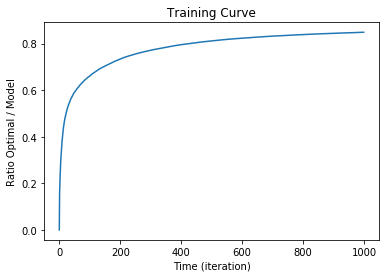

In [47]:
plt.plot(avg_ratio_est_vs_opt)
plt.title("Training Curve")
plt.xlabel("Time (iteration)")
plt.ylabel("Ratio Optimal / Model")

The figure shows the evolution of the average reward obtained by the gready policy on the Q function as this is being learned over time. We observe that in first few iterations, the ratio is close to zero, showing that the randomly initialized function Q is unable to choose the right arms, but over time Q learns to approximate the value of each arm for each bandit and the ratio between the optimal reward and the reward obtained from the learned value function Q tends to 1.